# Synthetic results analysis

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np
plt.style.use("bmh")
plt.rcParams["figure.figsize"] = (8, 6)
plt.rcParams["figure.dpi"]     = 150

## Utils

In [2]:
def chamfer(df, prefix, legend, threshold_bnds=(0.00, 0.3), color="gray"):
    import matplotlib.pyplot as plt
    
    pattern = re.compile(r"refined_chamfer_(.*)")
    thresholds = []

    for col in df.columns:
        match = pattern.match(col)
        if match:
            thresholds.append(match.group(1))
        
    cd_t = []    
    t = []
    for th in thresholds:
        if float(th) < threshold_bnds[0] or float(th) > threshold_bnds[1]: continue
        cd = df[f"{prefix}_chamfer_{th}"].replace(1e7, np.nan).mean()
        cd_t.append(cd)
        t.append(float(th))
     
     
    plt.plot(t, cd_t, label=legend, color=color)
    plt.xlabel("Threshold [Prob]")
    plt.ylabel("d_chamfer [vox]")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    
    
def chamfer_adaptive(df, color="black", line="--", suffix="(diffusion)"):
    import matplotlib.pyplot as plt
    mean_val = df["refined_chamfer_adaptive"].replace(1e7, np.nan).mean()
    plt.axhline(
        y=mean_val,
        color=color,      # choose a color
        linestyle=line,     # dashed line for clarity
        linewidth=1.5,
        label=f"adaptive threshold mean ({mean_val:.2f}) [vox] {suffix}"
    )
    plt.legend(loc="right")
    plt.tight_layout()

def emd_adaptive(df, color="black", line="--", suffix="(diffusion)"):
    import matplotlib.pyplot as plt
    mean_val = df["refined_emd_adaptive"].mean()
    plt.axhline(
        y=mean_val,
        color=color,      # choose a color
        linestyle=line,     # dashed line for clarity
        linewidth=1.5,
        label=f"adaptive threshold mean ({mean_val:.2f}) [vox] {suffix}"
    )
    plt.legend(loc="right")
    plt.tight_layout()

def dice3d(df, prefix, legend, threshold_bnds=(0, 1), color="gray"):
    import matplotlib.pyplot as plt
    
    pattern = re.compile(r"refined_chamfer_(.*)")
    thresholds = []

    for col in df.columns:
        match = pattern.match(col)
        if match:
            thresholds.append(match.group(1))
        
    cd_t = []    
    t = []
    for th in thresholds:
        if float(th) < threshold_bnds[0] or float(th) > threshold_bnds[1]: continue
        cd = df[f"{prefix}_dice3d_{th}"].mean()
        cd_t.append(cd)
        t.append(float(th))
     
     
    plt.plot(t, cd_t, label=legend, color=color)
    plt.xlabel("Threshold [Prob]")
    plt.ylabel("Dice3d [Frac]")
    plt.title(f"Dice3d")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()


def dice3d_adaptive(df, color="black", line="--", suffix="(diffusion)"):
    import matplotlib.pyplot as plt
    mean_val = df["refined_dice3d_adaptive"].mean()
    plt.axhline(
        y=mean_val,
        color=color,      # choose a color
        linestyle=line,     # dashed line for clarity
        linewidth=1.5,
        label=f"adaptive threshold mean ({mean_val:.2f}) {suffix}"
    )
    plt.legend(loc="right")


def metric_difference(df, metric_name, log=False, inverted=False, color="gray", legend=""):
    pattern = re.compile(r"refined_dice3d_(.*)")
    thresholds = []

    for col in df.columns:
        match = pattern.match(col)
        if match:
            thresholds.append(match.group(1))
        
    d3d_t = []    
    t = []
    for th in thresholds:
        d3d = df[f"refined_{metric_name}_{th}"].mean()
        d3d_bp = df[f"backproj_{metric_name}_{th}"].mean()
        t.append(float(th))
        if inverted: d3d_t.append(d3d_bp - d3d)
        else: d3d_t.append(d3d - d3d_bp)

    import matplotlib.pyplot as plt

    plt.plot(t, d3d_t, color=color, label=legend)
    plt.ylabel("difference [Frac]")
    plt.xlabel("threshold [Prob]")
    if log: plt.yscale("log")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    
def metric_difference_adaptive(df, metric_name, color="black", line="--", suffix="(diffusion)"):
    import matplotlib.pyplot as plt
    mean_val = (df[f"refined_{metric_name}_adaptive"] - df[f"backproj_{metric_name}_adaptive"]).mean()
    plt.axhline(
        y=mean_val,
        color=color,      # choose a color
        linestyle=line,     # dashed line for clarity
        linewidth=1.5,
        label=f"adaptive threshold mean ({mean_val:.2f}) {suffix}"
    )
    plt.legend(loc="lower right")


def latex_make_table(h, v_ours, v_gan, caption="", label=""):
    table = r"\begin{table}\begin{center}\begin{tabular}{lc}" + "\n"
    table += r"\hline" + "\n"
    table += f"Model & {h} \\\\\n"
    table += r"\hline" + "\n"
    table += f"Ours & {v_ours:.2f} \\\\\n"
    table += f"Baseline (gan) & {v_gan:.2f} \\\\\n"
    table += r"\hline" + "\n"
    table += r"\end{tabular}\end{center}" + "\n"
    table += r"\caption{" + caption + r" \label{" + label + r"}}" + "\n"
    table += r"\end{table}" + "\n"
    return table


def mean_ci(series, n_boot=10000, confidence=0.95, seed=42):
    import numpy as np
    rng = np.random.default_rng(seed)
    data = series.dropna().values
    means = [np.mean(rng.choice(data, size=len(data), replace=True)) for _ in range(n_boot)]
    lower, upper = np.percentile(means, [(1 - confidence) / 2 * 100, (1 + confidence) / 2 * 100])
    return np.mean(data), lower, upper

def ci_pretty(df, col):
    mean, lo, hi = mean_ci(df[col].replace(1e7, np.nan))
    print(f"{mean:.2f} ({lo:.2f}-{hi:.2f})")

## Right

In [26]:
df_diffusion = pd.read_csv("../data/synthetic_diffusion_right.csv")
df_unet = pd.read_csv("../data/synthetic_unet_right.csv")
df_gan = pd.read_csv("../data/synthetic_gan_right.csv")


df_adaptive_diffusion = pd.read_csv("../data/synthetic_adaptive_diffusion_right.csv")
df_adaptive_unet = pd.read_csv("../data/synthetic_adaptive_unet_right.csv")
df_adaptive_gan = pd.read_csv("../data/synthetic_adaptive_gan_right.csv")


df_best_diffusion = pd.read_csv("../data/synthetic_both_right.csv")
# df_diffusion_motion = pd.read_csv("../data/synthetic_motion_right.csv")


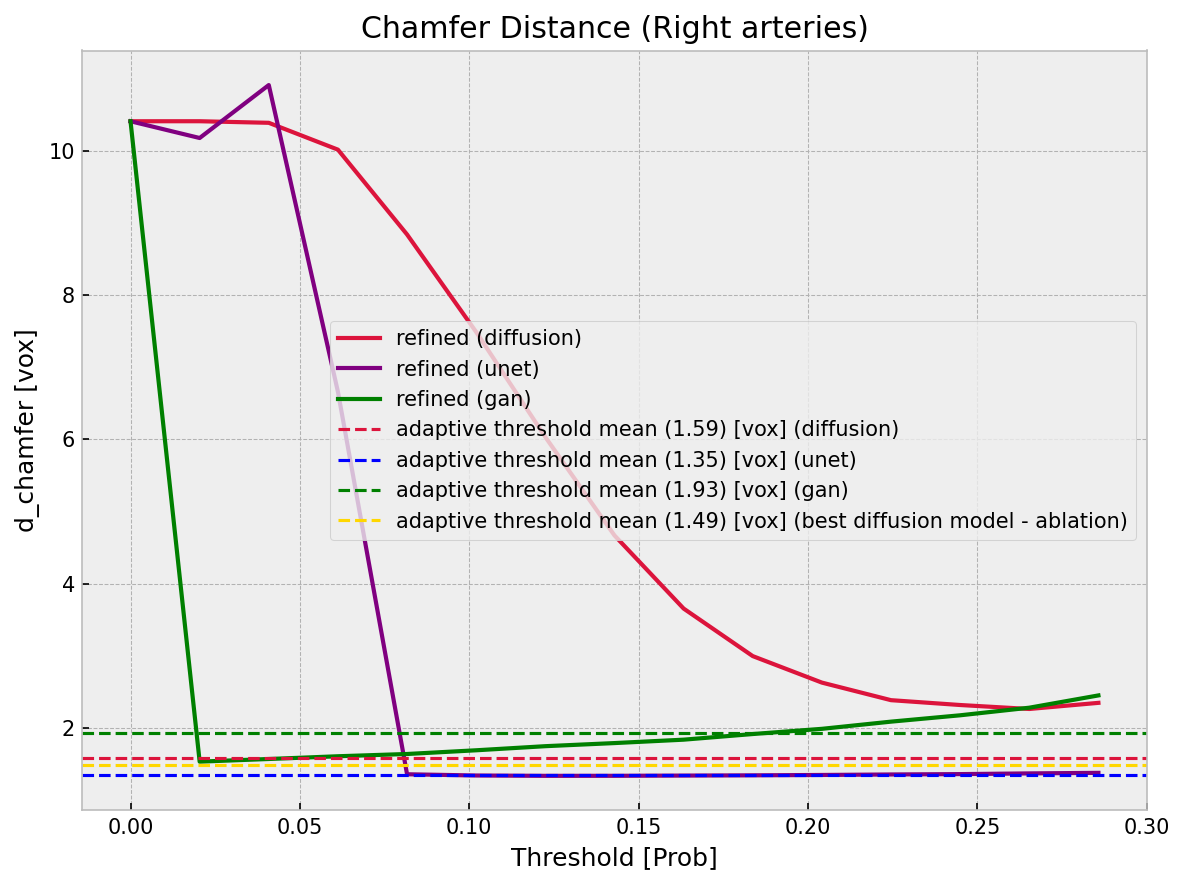

In [27]:
plt.title(f"Chamfer Distance (Right arteries)")
chamfer(df_diffusion, prefix="refined", legend="refined (diffusion)", color="crimson")
chamfer(df_unet, prefix="refined", legend="refined (unet)", color="purple")
chamfer(df_gan, prefix="refined", legend="refined (gan)", color="green")
chamfer_adaptive(df_adaptive_diffusion, color="crimson")
chamfer_adaptive(df_adaptive_unet, color="blue", suffix="(unet)")
chamfer_adaptive(df_adaptive_gan, color="green", suffix="(gan)")
chamfer_adaptive(df_best_diffusion, color="gold", suffix="(best diffusion model - ablation)")


Text(0.5, 1.0, 'Dice3d (Right arteries)')

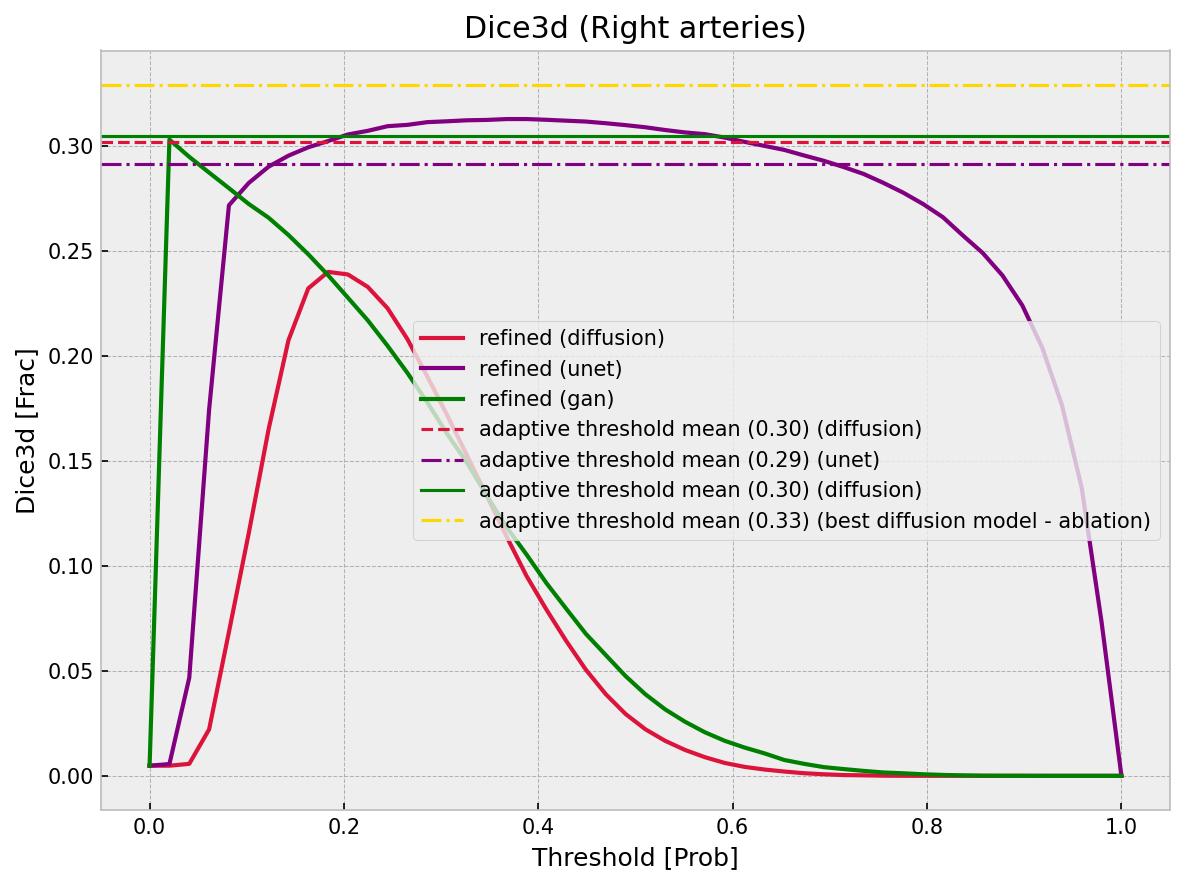

In [29]:
dice3d(df_diffusion, prefix="refined", legend="refined (diffusion)", color="crimson")
dice3d(df_unet, prefix="refined", legend="refined (unet)", color="purple")
dice3d(df_gan, prefix="refined", legend="refined (gan)", color="green")

dice3d_adaptive(df_adaptive_diffusion, color="crimson")
dice3d_adaptive(df_adaptive_unet, color="purple", line="-.", suffix="(unet)")
dice3d_adaptive(df_adaptive_gan, line="-", color="green")

dice3d_adaptive(df_best_diffusion, color="gold", line="-.", suffix="(best diffusion model - ablation)")
plt.title(f"Dice3d (Right arteries)")


In [14]:
ci_pretty(df_adaptive_diffusion, "refined_chamfer_adaptive")
ci_pretty(df_adaptive_diffusion, "refined_dice3d_adaptive")
ci_pretty(df_adaptive_diffusion, "refined_Ot(1)_adaptive")
ci_pretty(df_adaptive_diffusion, "refined_Ot(2)_adaptive")
ci_pretty(df_adaptive_diffusion, "PSNR")
ci_pretty(df_adaptive_diffusion, "elapsed")

ci_pretty(df_adaptive_diffusion, "chamfer_distance0")
ci_pretty(df_adaptive_diffusion, "chamfer_distance1")
ci_pretty(df_adaptive_diffusion, "dice2d0")
ci_pretty(df_adaptive_diffusion, "dice2d1")

ci_pretty(df_adaptive_diffusion, "interpret_frac")

1.59 (1.51-1.67)
0.30 (0.29-0.31)
0.57 (0.55-0.58)
0.76 (0.75-0.78)
28.45 (28.19-28.71)
2.71 (2.71-2.71)
10.45 (9.84-11.10)
6.72 (6.30-7.17)
0.42 (0.41-0.44)
0.56 (0.55-0.58)
0.14 (0.13-0.15)


In [15]:
ci_pretty(df_adaptive_diffusion, "backproj_chamfer_adaptive")
ci_pretty(df_adaptive_diffusion, "backproj_dice3d_adaptive")
ci_pretty(df_adaptive_diffusion, "backproj_Ot(1)_adaptive")
ci_pretty(df_adaptive_diffusion, "backproj_Ot(2)_adaptive")

ci_pretty(df_adaptive_diffusion, "bp_chamfer_distance0")
ci_pretty(df_adaptive_diffusion, "bp_chamfer_distance1")
ci_pretty(df_adaptive_diffusion, "bp_dice2d0")
ci_pretty(df_adaptive_diffusion, "bp_dice2d1")

3.25 (3.14-3.36)
0.10 (0.10-0.11)
0.22 (0.21-0.23)
0.36 (0.34-0.37)
10.45 (9.84-11.10)
6.72 (6.30-7.17)
0.42 (0.41-0.44)
0.56 (0.55-0.58)


In [12]:
ci_pretty(df_adaptive_unet, "refined_chamfer_adaptive")
ci_pretty(df_adaptive_unet, "refined_dice3d_adaptive")
ci_pretty(df_adaptive_unet, "refined_Ot(1)_adaptive")
ci_pretty(df_adaptive_unet, "refined_Ot(2)_adaptive")
ci_pretty(df_adaptive_unet, "PSNR")
ci_pretty(df_adaptive_unet, "elapsed")

ci_pretty(df_adaptive_unet, "chamfer_distance0")
ci_pretty(df_adaptive_unet, "chamfer_distance1")
ci_pretty(df_adaptive_unet, "dice2d0")
ci_pretty(df_adaptive_unet, "dice2d1")

ci_pretty(df_adaptive_unet, "interpret_frac")

1.35 (1.28-1.43)
0.29 (0.28-0.30)
0.51 (0.49-0.52)
0.70 (0.68-0.72)
33.90 (33.71-34.08)
0.01 (0.00-0.01)
8.87 (8.11-9.65)
5.83 (5.39-6.29)
0.48 (0.46-0.50)
0.59 (0.58-0.61)
0.30 (0.28-0.32)


In [10]:
ci_pretty(df_adaptive_gan, "refined_chamfer_adaptive")
ci_pretty(df_adaptive_gan, "refined_dice3d_adaptive")
ci_pretty(df_adaptive_gan, "refined_Ot(1)_adaptive")
ci_pretty(df_adaptive_gan, "refined_Ot(2)_adaptive")
ci_pretty(df_adaptive_gan, "PSNR")
ci_pretty(df_adaptive_gan, "elapsed")

ci_pretty(df_adaptive_gan, "chamfer_distance0")
ci_pretty(df_adaptive_gan, "chamfer_distance1")
ci_pretty(df_adaptive_gan, "dice2d0")
ci_pretty(df_adaptive_gan, "dice2d1")

ci_pretty(df_adaptive_gan, "interpret_frac")

1.93 (1.82-2.04)
0.30 (0.29-0.32)
0.54 (0.51-0.56)
0.70 (0.68-0.71)
39.63 (39.33-39.91)
0.01 (0.01-0.01)
10.21 (9.48-10.97)
8.45 (7.91-9.01)
0.44 (0.42-0.46)
0.53 (0.52-0.54)
0.21 (0.20-0.23)


In [16]:
ci_pretty(df_best_diffusion, "refined_chamfer_adaptive")
ci_pretty(df_best_diffusion, "refined_dice3d_adaptive")
ci_pretty(df_best_diffusion, "refined_Ot(1)_adaptive")
ci_pretty(df_best_diffusion, "refined_Ot(2)_adaptive")
ci_pretty(df_best_diffusion, "PSNR")
ci_pretty(df_best_diffusion, "elapsed")


ci_pretty(df_best_diffusion, "chamfer_distance0")
ci_pretty(df_best_diffusion, "chamfer_distance1")
ci_pretty(df_best_diffusion, "dice2d0")
ci_pretty(df_best_diffusion, "dice2d1")

ci_pretty(df_best_diffusion, "interpret_frac")

1.49 (1.41-1.59)
0.33 (0.32-0.34)
0.59 (0.58-0.61)
0.78 (0.77-0.79)
32.92 (32.68-33.16)
2.71 (2.71-2.71)
8.70 (8.10-9.34)
6.28 (5.69-6.91)
0.50 (0.48-0.51)
0.62 (0.61-0.63)
0.20 (0.19-0.21)


In [ ]:
ci_pretty(df_diffusion_motion, "refined_chamfer_adaptive")
ci_pretty(df_diffusion_motion, "refined_dice3d_adaptive")
ci_pretty(df_diffusion_motion, "refined_Ot(1)_adaptive")
ci_pretty(df_diffusion_motion, "refined_Ot(2)_adaptive")
ci_pretty(df_diffusion_motion, "PSNR")
ci_pretty(df_diffusion_motion, "elapsed")

ci_pretty(df_diffusion_motion, "chamfer_distance0")
ci_pretty(df_diffusion_motion, "chamfer_distance1")
ci_pretty(df_diffusion_motion, "dice2d0")
ci_pretty(df_diffusion_motion, "dice2d1")

ci_pretty(df_diffusion_motion, "interpret_frac")

# Left

In [33]:
df_diffusion = pd.read_csv("../data/synthetic_diffusion_left.csv")
df_unet = pd.read_csv("../data/synthetic_unet_left.csv")
df_gan = pd.read_csv("../data/synthetic_gan_left.csv")

df_adaptive_diffusion = pd.read_csv("../data/synthetic_adaptive_diffusion_left.csv")
df_adaptive_unet = pd.read_csv("../data/synthetic_adaptive_unet_left.csv")
df_adaptive_gan = pd.read_csv("../data/synthetic_adaptive_gan_left.csv")

df_best_diffusion = pd.read_csv("../data/synthetic_no_projections_left.csv")
# df_diffusion_motion = pd.read_csv("../data/synthetic_motion_left.csv")

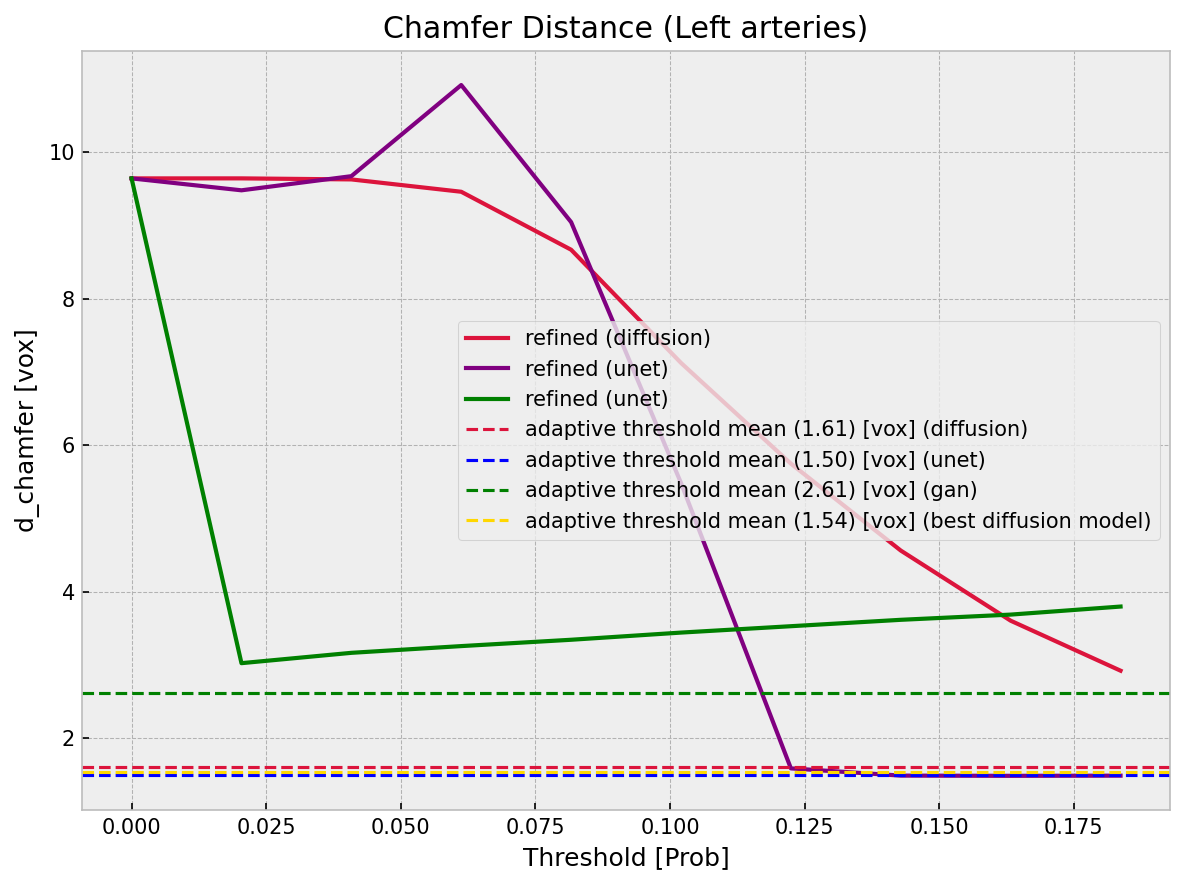

In [34]:
plt.title(f"Chamfer Distance (Left arteries)")
chamfer(df_diffusion, prefix="refined", legend="refined (diffusion)", color="crimson", threshold_bnds=(0, 0.2))
chamfer(df_unet, prefix="refined", legend="refined (unet)", color="purple", threshold_bnds=(0, 0.2))
chamfer(df_gan, prefix="refined", legend="refined (unet)", color="green", threshold_bnds=(0, 0.2))

chamfer_adaptive(df_adaptive_diffusion, color="crimson")
chamfer_adaptive(df_adaptive_unet, color="blue", suffix="(unet)")
chamfer_adaptive(df_adaptive_gan, color="green", suffix="(gan)")
chamfer_adaptive(df_best_diffusion, color="gold", suffix="(best diffusion model)")

Text(0.5, 1.0, 'Dice3d (Left arteries)')

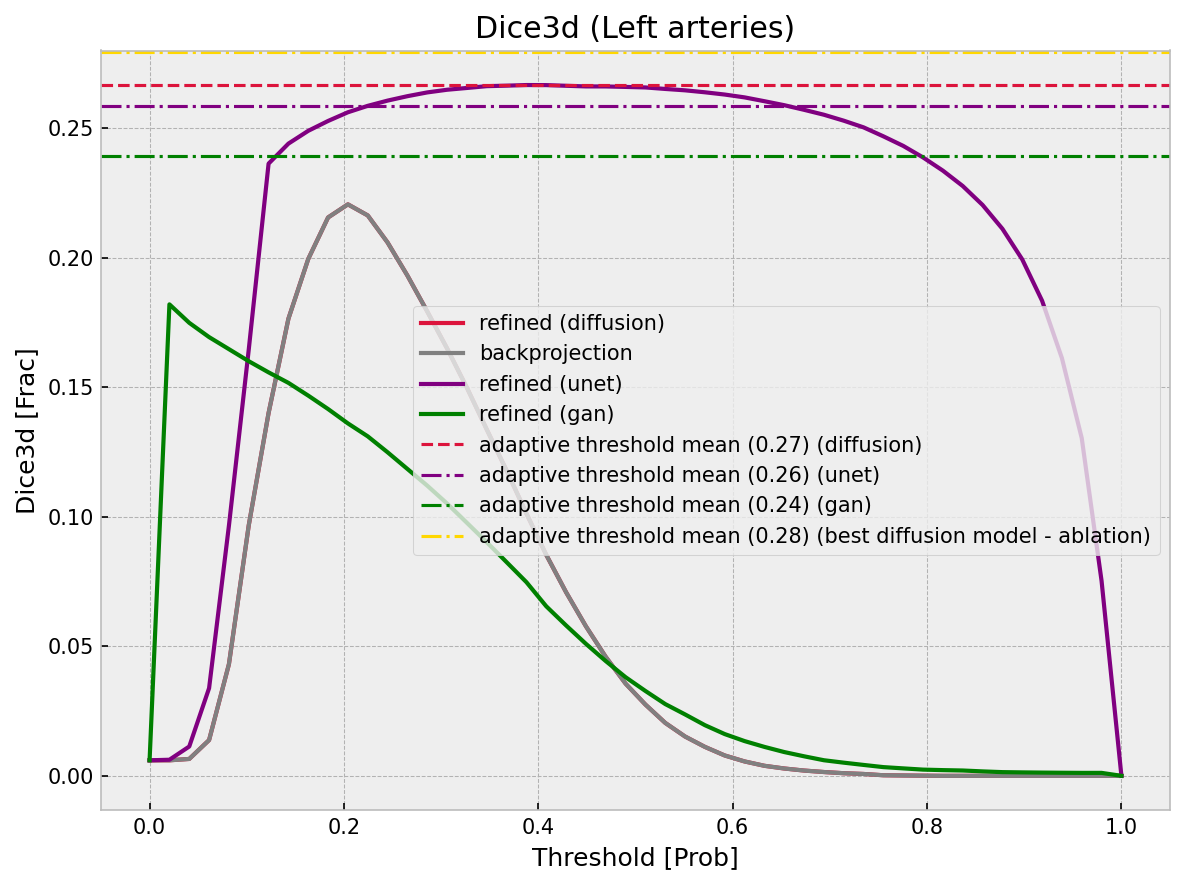

In [32]:
dice3d(df_diffusion, prefix="refined", legend="refined (diffusion)", color="crimson")
dice3d(df_diffusion, prefix="backproj", legend="backprojection", color="gray")
dice3d(df_unet, prefix="refined", legend="refined (unet)", color="purple")
dice3d(df_gan, prefix="refined", legend="refined (gan)", color="green")

dice3d_adaptive(df_adaptive_diffusion, color="crimson")
dice3d_adaptive(df_adaptive_unet, color="purple", line="-.", suffix="(unet)")
dice3d_adaptive(df_adaptive_gan, color="green", line="-.", suffix="(gan)")
dice3d_adaptive(df_best_diffusion, color="gold", line="-.", suffix="(best diffusion model - ablation)")
plt.title(f"Dice3d (Left arteries)")


In [35]:
ci_pretty(df_adaptive_diffusion, "refined_chamfer_adaptive")
ci_pretty(df_adaptive_diffusion, "refined_dice3d_adaptive")
ci_pretty(df_adaptive_diffusion, "refined_Ot(1)_adaptive")
ci_pretty(df_adaptive_diffusion, "refined_Ot(2)_adaptive")
ci_pretty(df_adaptive_diffusion, "PSNR")
ci_pretty(df_adaptive_diffusion, "elapsed")

ci_pretty(df_adaptive_diffusion, "chamfer_distance0")
ci_pretty(df_adaptive_diffusion, "chamfer_distance1")
ci_pretty(df_adaptive_diffusion, "dice2d0")
ci_pretty(df_adaptive_diffusion, "dice2d1")

ci_pretty(df_adaptive_diffusion, "interpret_frac")

1.61 (1.54-1.68)
0.27 (0.26-0.28)
0.51 (0.49-0.52)
0.70 (0.68-0.71)
27.46 (27.19-27.71)
2.70 (2.70-2.70)
15.05 (11.79-18.63)
16.90 (13.72-20.36)
0.57 (0.55-0.58)
0.49 (0.47-0.50)
0.23 (0.22-0.24)


In [36]:
ci_pretty(df_adaptive_diffusion, "backproj_chamfer_adaptive")
ci_pretty(df_adaptive_diffusion, "backproj_dice3d_adaptive")
ci_pretty(df_adaptive_diffusion, "backproj_Ot(1)_adaptive")
ci_pretty(df_adaptive_diffusion, "backproj_Ot(2)_adaptive")

ci_pretty(df_adaptive_diffusion, "bp_chamfer_distance0")
ci_pretty(df_adaptive_diffusion, "bp_chamfer_distance1")
ci_pretty(df_adaptive_diffusion, "bp_dice2d0")
ci_pretty(df_adaptive_diffusion, "bp_dice2d1")

4.10 (3.98-4.21)
0.09 (0.09-0.10)
0.19 (0.18-0.20)
0.30 (0.28-0.31)
15.05 (11.79-18.63)
16.90 (13.72-20.36)
0.57 (0.55-0.58)
0.49 (0.47-0.50)


In [41]:
ci_pretty(df_adaptive_unet, "refined_chamfer_adaptive")
ci_pretty(df_adaptive_unet, "refined_dice3d_adaptive")
ci_pretty(df_adaptive_unet, "refined_Ot(1)_adaptive")
ci_pretty(df_adaptive_unet, "refined_Ot(2)_adaptive")
ci_pretty(df_adaptive_unet, "PSNR")
ci_pretty(df_adaptive_unet, "elapsed")

ci_pretty(df_adaptive_unet, "chamfer_distance0")
ci_pretty(df_adaptive_unet, "chamfer_distance1")
ci_pretty(df_adaptive_unet, "dice2d0")
ci_pretty(df_adaptive_unet, "dice2d1")

ci_pretty(df_adaptive_unet, "interpret_frac")

1.50 (1.42-1.60)
0.26 (0.25-0.27)
0.46 (0.44-0.48)
0.65 (0.62-0.67)
31.13 (30.97-31.29)
0.01 (0.01-0.01)
13.47 (8.34-19.62)
15.99 (10.89-21.97)
0.59 (0.57-0.61)
0.52 (0.49-0.54)
0.43 (0.40-0.45)


In [43]:
ci_pretty(df_adaptive_gan, "refined_chamfer_adaptive")
ci_pretty(df_adaptive_gan, "refined_dice3d_adaptive")
ci_pretty(df_adaptive_gan, "refined_Ot(1)_adaptive")
ci_pretty(df_adaptive_gan, "refined_Ot(2)_adaptive")
ci_pretty(df_adaptive_gan, "PSNR")
ci_pretty(df_adaptive_gan, "elapsed")

ci_pretty(df_adaptive_gan, "chamfer_distance0")
ci_pretty(df_adaptive_gan, "chamfer_distance1")
ci_pretty(df_adaptive_gan, "dice2d0")
ci_pretty(df_adaptive_gan, "dice2d1")

ci_pretty(df_adaptive_gan, "interpret_frac")

2.61 (2.45-2.79)
0.24 (0.22-0.26)
0.44 (0.41-0.46)
0.60 (0.57-0.62)
39.04 (38.58-39.54)
0.01 (0.01-0.01)
19.75 (14.28-26.11)
21.62 (16.21-27.86)
0.46 (0.44-0.48)
0.39 (0.37-0.41)
0.19 (0.17-0.20)


In [42]:
ci_pretty(df_best_diffusion, "refined_chamfer_adaptive")
ci_pretty(df_best_diffusion, "refined_dice3d_adaptive")
ci_pretty(df_best_diffusion, "refined_Ot(1)_adaptive")
ci_pretty(df_best_diffusion, "refined_Ot(2)_adaptive")
ci_pretty(df_best_diffusion, "PSNR")
ci_pretty(df_best_diffusion, "elapsed")

ci_pretty(df_best_diffusion, "chamfer_distance0")
ci_pretty(df_best_diffusion, "chamfer_distance1")
ci_pretty(df_best_diffusion, "dice2d0")
ci_pretty(df_best_diffusion, "dice2d1")

ci_pretty(df_best_diffusion, "interpret_frac")

1.54 (1.48-1.61)
0.28 (0.27-0.29)
0.51 (0.50-0.52)
0.70 (0.68-0.71)
28.89 (28.63-29.14)
2.71 (2.71-2.71)
14.45 (11.14-18.12)
15.98 (12.73-19.54)
0.60 (0.59-0.62)
0.53 (0.52-0.55)
0.34 (0.33-0.35)


In [71]:
ci_pretty(df_diffusion_motion, "refined_chamfer_adaptive")
ci_pretty(df_diffusion_motion, "refined_dice3d_adaptive")
ci_pretty(df_diffusion_motion, "refined_Ot(1)_adaptive")
ci_pretty(df_diffusion_motion, "refined_Ot(2)_adaptive")
ci_pretty(df_diffusion_motion, "PSNR")
ci_pretty(df_diffusion_motion, "elapsed")

ci_pretty(df_diffusion_motion, "chamfer_distance0")
ci_pretty(df_diffusion_motion, "chamfer_distance1")
ci_pretty(df_diffusion_motion, "dice2d0")
ci_pretty(df_diffusion_motion, "dice2d1")

ci_pretty(df_diffusion_motion, "interpret_frac")

2.64 (2.23-3.10)
0.16 (0.14-0.19)
0.35 (0.30-0.39)
0.54 (0.48-0.59)
27.08 (26.29-27.83)
2.69 (2.69-2.69)
10.04 (7.57-12.99)
19.49 (17.54-21.67)
0.56 (0.52-0.60)
0.31 (0.29-0.33)
1.00 (1.00-1.00)
